In [1]:
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np
from IPython import display
import time

import gym.spaces
import gym
import FastSLAM

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler

TrainingRecord = namedtuple('TrainingRecord', ['ep', 'reward', 'score'])
Transition = namedtuple('Transition', ['s', 'a', 'a_log_p', 'r', 's_'])

In [2]:
N_eps = 2000
sim_time = 15.0
gamma = 0.9
_render = False
log_interval = 10
state_size = 12

clip_param = 0.2
max_grad_norm = 0.5
ppo_epoch = 10
buffer_capacity, batch_size = 1500, 64

In [3]:
class ActorNet(nn.Module):

    def __init__(self):
        super(ActorNet, self).__init__()
        self.fc1 = nn.Linear(state_size, 100)
        self.fc2 = nn.Linear(100, 100)
        self.mu_head = nn.Linear(100, 1)
        self.sigma_head = nn.Linear(100, 1)

    def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        mu = self.mu_head(x)
        sigma = torch.sigmoid(self.sigma_head(x))
        return (mu, sigma)
#         return mu, 0.0001


class CriticNet(nn.Module):

    def __init__(self):
        super(CriticNet, self).__init__()
        self.fc1 = nn.Linear(state_size, 100)
        self.fc2 = nn.Linear(100, 100)
        self.v_head = nn.Linear(100, 1)

    def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        state_value = self.v_head(x)
        return state_value

In [4]:
class Agent():

    def __init__(self):
        self.training_step = 0
        self.anet = ActorNet().float()
        self.cnet = CriticNet().float()
        self.buffer = []
        self.counter = 0

        self.optimizer_a = optim.Adam(self.anet.parameters(), lr=1e-4)
        self.optimizer_c = optim.Adam(self.cnet.parameters(), lr=3e-4)

    def select_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        with torch.no_grad():
            (mu, sigma) = self.anet(state)
    
        dist = Normal(mu, sigma)
        action = dist.sample()
        action_log_prob = dist.log_prob(action)
#         action.clamp(-2.0, 2.0)
        return action.item(), action_log_prob.item(), mu.numpy()[0][0], sigma.numpy()[0][0]
#         return action.item(), action_log_prob.item(), mu.numpy()[0][0], sigma

    def get_value(self, state):

        state = torch.from_numpy(state).float().unsqueeze(0)
        with torch.no_grad():
            state_value = self.cnet(state)
        return state_value.item()

    def store(self, transition):
        self.buffer.append(transition)
        self.counter += 1
        return self.counter % buffer_capacity == 0

    def update(self):
        self.training_step += 1

        s = torch.tensor([t.s for t in self.buffer], dtype=torch.float)
        a = torch.tensor([t.a for t in self.buffer], dtype=torch.float).view(-1, 1)
        r = torch.tensor([t.r for t in self.buffer], dtype=torch.float).view(-1, 1)
        s_ = torch.tensor([t.s_ for t in self.buffer], dtype=torch.float)

        old_action_log_probs = torch.tensor(
            [t.a_log_p for t in self.buffer], dtype=torch.float).view(-1, 1)

        r = (r - r.mean()) / (r.std() + 1e-5)
        with torch.no_grad():
            target_v = r + gamma * self.cnet(s_)

        adv = (target_v - self.cnet(s)).detach()

        for _ in range(ppo_epoch):
            for index in BatchSampler(
                    SubsetRandomSampler(range(buffer_capacity)), batch_size, False):

                (mu, sigma) = self.anet(s[index])
                dist = Normal(mu, sigma)
                action_log_probs = dist.log_prob(a[index])
                ratio = torch.exp(action_log_probs - old_action_log_probs[index])

                surr1 = ratio * adv[index]
                surr2 = torch.clamp(ratio, 1.0 - clip_param,
                                    1.0 + clip_param) * adv[index]
                action_loss = -torch.min(surr1, surr2).mean()

                self.optimizer_a.zero_grad()
                action_loss.backward()
                nn.utils.clip_grad_norm_(self.anet.parameters(), max_grad_norm)
                self.optimizer_a.step()

                value_loss = F.smooth_l1_loss(self.cnet(s[index]), target_v[index])
                self.optimizer_c.zero_grad()
                value_loss.backward()
                nn.utils.clip_grad_norm_(self.cnet.parameters(), max_grad_norm)
                self.optimizer_c.step()

        del self.buffer[:]

In [5]:
env = gym.make('FastSLAM-v0')

agent = Agent()

opt_times = []
training_records = []
running_reward = 0
state = env.reset()

/home/akshay_shetty160992/.local/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [6]:
N_tr = len(training_records)

for i_ep in range(N_eps):
    score = 0
    state = env.reset()

    while env.time < sim_time:
        action, action_log_prob, _, _ = agent.select_action(state)
        state_, reward, done, _ = env.step([action])

        if _render:
            env.render_world()
            display.clear_output(wait=True)
            plt.pause(0.001)
        
        if agent.store(Transition(state, action, action_log_prob, reward, state_)):
            t1 = time.time()
            agent.update()
            t2 = time.time()
            opt_times.append(t2-t1)
            
        score += reward
        state = state_

    running_reward = running_reward * 0.9 + score * 0.1
    training_records.append(TrainingRecord(N_tr+i_ep, running_reward, score))

    if len(opt_times) == 0:
        avg_opt_time = 0.0
    else:
        avg_opt_time = sum(opt_times) / float(len(opt_times))
    
    if i_ep % log_interval == 0:
        print('Ep {}\tMoving average score: {:.2f}\tAverage opt time: {:.2f}\t'.format(N_tr+i_ep, running_reward, avg_opt_time))

Ep 0	Moving average score: 62.31	Average opt time: 0.00	
Ep 10	Moving average score: 60.33	Average opt time: 1.48	
Ep 20	Moving average score: 136.00	Average opt time: 1.23	
Ep 30	Moving average score: 113.24	Average opt time: 1.21	
Ep 40	Moving average score: 141.03	Average opt time: 1.22	
Ep 50	Moving average score: 231.13	Average opt time: 1.19	
Ep 60	Moving average score: 251.37	Average opt time: 1.22	
Ep 70	Moving average score: 237.75	Average opt time: 1.28	
Ep 80	Moving average score: 260.61	Average opt time: 1.28	
Ep 90	Moving average score: 291.43	Average opt time: 1.26	
Ep 100	Moving average score: 329.91	Average opt time: 1.24	
Ep 110	Moving average score: 365.18	Average opt time: 1.22	
Ep 120	Moving average score: 205.03	Average opt time: 1.23	
Ep 130	Moving average score: 258.96	Average opt time: 1.24	
Ep 140	Moving average score: 280.08	Average opt time: 1.25	
Ep 150	Moving average score: 341.11	Average opt time: 1.25	
Ep 160	Moving average score: 470.89	Average opt time:

Ep 1370	Moving average score: 168.11	Average opt time: 1.23	
Ep 1380	Moving average score: 143.37	Average opt time: 1.23	
Ep 1390	Moving average score: 224.64	Average opt time: 1.24	
Ep 1400	Moving average score: 306.86	Average opt time: 1.24	
Ep 1410	Moving average score: 292.17	Average opt time: 1.24	
Ep 1420	Moving average score: 240.24	Average opt time: 1.24	
Ep 1430	Moving average score: 229.07	Average opt time: 1.23	
Ep 1440	Moving average score: 331.30	Average opt time: 1.23	
Ep 1450	Moving average score: 449.83	Average opt time: 1.23	
Ep 1460	Moving average score: 446.46	Average opt time: 1.24	
Ep 1470	Moving average score: 482.65	Average opt time: 1.24	
Ep 1480	Moving average score: 267.79	Average opt time: 1.24	
Ep 1490	Moving average score: 292.86	Average opt time: 1.23	
Ep 1500	Moving average score: 369.00	Average opt time: 1.24	
Ep 1510	Moving average score: 272.09	Average opt time: 1.24	
Ep 1520	Moving average score: 126.65	Average opt time: 1.24	
Ep 1530	Moving average s

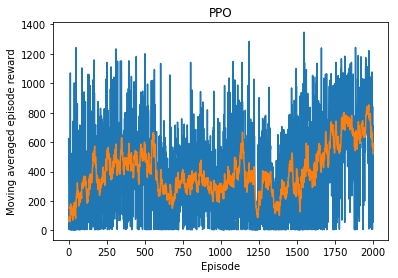

In [7]:
# env.close()
plt.plot([r.ep for r in training_records], [r.score for r in training_records])
plt.plot([r.ep for r in training_records], [r.reward for r in training_records])
plt.title('PPO')
plt.xlabel('Episode')
plt.ylabel('Moving averaged episode reward')
plt.show()

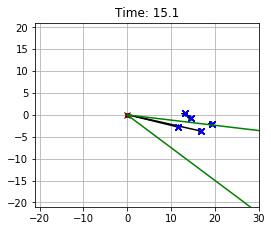

In [12]:
# env = gym.make('FastSLAM-v0')
# agent = Agent()
state = env.reset()
a_, r_, mu_, sigma_, _state_ = [], [], [], [], []

while env.time < sim_time:
    _state_.append(state)
#     print(state)
    action, action_log_prob, mu, sigma = agent.select_action(state)
#     dist = Normal(mu, 0.0001*sigma)
#     action = dist.sample()
    state_, reward, done, _ = env.step([action])
    a_.append([action])
    r_.append(reward)
    mu_.append(mu)
    sigma_.append(sigma)
    state = state_
    env.render_world()
    display.clear_output(wait=True)
    plt.pause(0.001)
    

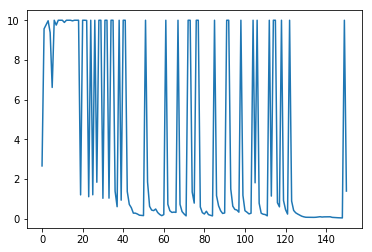

In [13]:
plt.plot(r_)
# np.rad2deg(env.theta[0])